在我之前的博客中我们介绍了文本的多分类的方法,我们还尝试了各种分类模型,比如朴素贝叶斯、逻辑回归、支持向量机和随机森林等并且都取得了非常不错的效果。今天我们使用深度学习中的LSTM（Long Short-Term Memory）长短期记忆网络，它是一种时间循环神经网络，适合于处理和预测时间序列中间隔和延迟相对较长的重要事件。
LSTM 已经在科技领域有了多种应用。基于 LSTM 的系统可以学习翻译语言、控制机器人、图像分析、文档摘要、语音识别图像识别、手写识别、控制聊天机器人、预测疾病、点击率和股票、合成音乐等等任务。今天我们用它来实现一下文本多分类，相信会取得较好的效果。

# 数据

我们的数据来自于互联网，你可以在这里下载,数据中包含了10 个类别（书籍、平板、手机、水果、洗发水、热水器、蒙牛、衣服、计算机、酒店），共 6 万多条评论数据 首先查看一下我们的数据，这些数据都是来自于电商网站的用户评价数据,我们想要把不同评价数据分到不同的分类中去,且每条数据只能对应10个类中的一个类。

[LSTM二分类和多分类代码的区别](https://www.it1352.com/1525153.html)

数据下载地址:https://github.com/SophonPlus/ChineseNlpCorpus/blob/master/datasets/online_shopping_10_cats/intro.ipynb


In [5]:
#coding=utf-8
# %matplotlib inline
import pandas as pd
import matplotlib
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams['font.sans-serif'] = ['SimHei']  
plt.rcParams['axes.unicode_minus'] = False 
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Dense, Embedding, LSTM, SpatialDropout1D
from sklearn.model_selection import train_test_split
from keras.utils.np_utils import to_categorical
from keras.callbacks import EarlyStopping
from keras.layers import Dropout
import jieba as jb
import re
import warnings

warnings.filterwarnings('ignore')
warnings.simplefilter('ignore')

In [6]:
df = pd.read_csv('./data/online_shopping_10_cats.csv')
df=df[['cat','review']]
print("数据总量: %d ." % len(df))
df.sample(10)

数据总量: 62774 .


,cat,review
5140,平板,618活动比平时便宜，物流也没怎么受影响，两天就到了。M3我觉得可以算是平板界的旗舰了，跟家...
18282,水果,与一切过程无关，这个程度只与发货出库有关，我也不想说什么
9548,平板,买个**东西！真的只能看电视！玩王者荣耀 呵呵 开始不相信现在信了 不如苹果2688不如果苹...
8426,平板,这是我买的第三个华为M2，老爸一个，外甥女一个，今天给儿子买的！内存不N小，又配了闪存卡，超...
57712,酒店,1、酒店还算可以，设施有点旧，四星级勉强2、地处陈家坪，没有大型商场超市，背后有个美食街。送...
48945,计算机,"首先性价比不错,收到货屏幕没有坏点,送了散热底座温度控制能平均低12度左右 ,不运行大程序发..."
58320,酒店,预定的时候看见有大床房是没有窗户的，特意避开选择这种房型，选择了价格较高的舒适大床房，结果进...
36139,洗发水,洗发水都弄的满瓶都是，什么玩意。必须差评，还有就是发货发了几天
35522,洗发水,我之前用过霸王生姜，一洗头皮就有点发热。后面霸王下架了，在信和超市买了这产品，用了同样的效果...
41138,衣服,本来抱着试试的心态，没有想到物超所值！宝贝包装的也很好。客服态度很好！很贴心！物流也快，没两...


In [7]:
print("在 cat 列中总共有 %d 个空值." % df['cat'].isnull().sum())
print("在 review 列中总共有 %d 个空值." % df['review'].isnull().sum())
df[df.isnull().values==True]
df = df[pd.notnull(df['review'])]


在 cat 列中总共有 0 个空值.
在 review 列中总共有 1 个空值.


In [8]:
d = {'cat':df['cat'].value_counts().index, 'count': df['cat'].value_counts()}
df_cat = pd.DataFrame(data=d).reset_index(drop=True)
df_cat

,cat,count
0,平板,10000
1,水果,10000
2,洗发水,10000
3,衣服,10000
4,酒店,10000
5,计算机,3992
6,书籍,3851
7,手机,2323
8,蒙牛,2033
9,热水器,574


Text(0.5, 0, '类目')

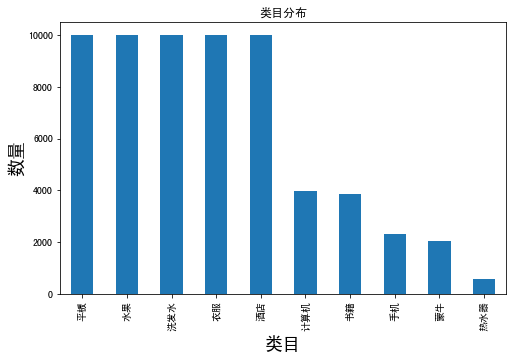

In [9]:
df_cat.plot(x='cat', y='count', kind='bar', legend=False,  figsize=(8, 5))
plt.title("类目分布")
plt.ylabel('数量', fontsize=18)
plt.xlabel('类目', fontsize=18)


# 数据预处理

 接下来我们要将cat类转换成id，这样便于以后的分类模型的训练。

In [10]:
df['cat_id'] = df['cat'].factorize()[0]
cat_id_df = df[['cat', 'cat_id']].drop_duplicates().sort_values('cat_id').reset_index(drop=True)
cat_to_id = dict(cat_id_df.values)
id_to_cat = dict(cat_id_df[['cat_id', 'cat']].values)
df.sample(10)


,cat,review,cat_id
50734,计算机,还不错，比较实用，装系统千万别看网上傻比功略，纯粹是没事找事，什么用U盘虚拟光驱iso，都是...,8
26132,水果,没啥味道，特别小特别小，千万别买，特别不值,3
443,书籍,仔细回想这本文集，发现自己喜欢的只是写《教室朝南，没有风筝》的麻宁，不知道是她成长了还是自己...,0
48163,衣服,物流慢，掉色，掉色掉色，重要的事情说三遍,7
3760,书籍,本书其实没说什么，也看不出价值在哪，作者倒是牛，把西医批评的一无是处，感觉就是根本不懂科学,0
37503,蒙牛,当初蒙牛让中粮入股是明智之举，国有控股，伊利的骚扰就少了很多。当然，也由此带来了管理质量下降...,6
23904,水果,货物刚收到，封箱完整，只有11个，而且很小超小，说好的12个果怎么少了一个，而且说好的70-...,3
50711,计算机,华硕承诺无亮点。送的鼠标时罗技的。本子的散热也比想象的好很多,8
51941,计算机,无线网卡没有开关，每次开机后需要用键盘组合键开启无线网卡。即使没有开关也可以像dell家用机...,8
50751,计算机,烤漆面板相当漂亮！各项功能都很齐全，送人的，很满意呢！虽然还没有试用。,8


In [11]:
cat_id_df

,cat,cat_id
0,书籍,0
1,平板,1
2,手机,2
3,水果,3
4,洗发水,4
5,热水器,5
6,蒙牛,6
7,衣服,7
8,计算机,8
9,酒店,9


我们将cat转换成了Id(0到9),由于我们的评价内容都是中文,所以要对中文进行一些预处理工作,这包括删除文本中的标点符号,特殊符号,还要删除一些无意义的常用词(stopword),因为这些词和符号对系统分析预测文本的内容没有任何帮助,反而会增加计算的复杂度和增加系统开销,所有在使用这些文本数据之前必须要将它们清理干净。

In [12]:
#定义删除除字母,数字，汉字以外的所有符号的函数
def remove_punctuation(line):
    line = str(line)
    if line.strip()=='':
        return ''
    rule = re.compile(u"[^a-zA-Z0-9\u4E00-\u9FA5]")
    line = rule.sub('',line)
    return line
 
def stopwordslist(filepath):  
    stopwords = [line.strip() for line in open(filepath, 'r', encoding='utf-8').readlines()]  
    return stopwords  

#加载停用词
stopwords = stopwordslist("./data/chineseStopWords.txt")

中文停用词包含了很多日常使用频率很高的常用词,如 吧，吗，呢，啥等一些感叹词等,这些高频常用词无法反应出文本的主要意思,所以要被过滤掉。

In [13]:
#删除除字母,数字，汉字以外的所有符号
df['clean_review'] = df['review'].apply(remove_punctuation)
df.sample(10)

,cat,review,cat_id,clean_review
1851,书籍,本书读完了，我个人感觉宋初的文人都以范仲淹等知识分子为自己的楷模，苏轼也一样。宋朝文人都以忧...,0,本书读完了我个人感觉宋初的文人都以范仲淹等知识分子为自己的楷模苏轼也一样宋朝文人都以忧国忧民...
58373,酒店,卫生条件不是太好。房间要臭气味。空调发出滴滴的声音。,9,卫生条件不是太好房间要臭气味空调发出滴滴的声音
40381,衣服,裤子很舒适，和衣服搭配很适合！,7,裤子很舒适和衣服搭配很适合
6270,平板,平板电脑上手体验一下，还可以对得起这个价格，物有所值，外观造型独特轻薄，全金属机身设计风格，...,1,平板电脑上手体验一下还可以对得起这个价格物有所值外观造型独特轻薄全金属机身设计风格反应迅速灵...
35084,洗发水,说的赠品呢，什么没有，，我选了半天真无语,4,说的赠品呢什么没有我选了半天真无语
19151,水果,苹果好小 希望味道haikeyi,3,苹果好小希望味道haikeyi
10245,平板,无语刚买不到一天降价50元,1,无语刚买不到一天降价50元
34245,洗发水,快递很差劲、到了也不打电话、两个包裹一个今天才找到,4,快递很差劲到了也不打电话两个包裹一个今天才找到
19799,水果,又脆又甜，个头大，大小均匀，好吃到爆了。一到就吃了3个，知道有多好吃了吧！,3,又脆又甜个头大大小均匀好吃到爆了一到就吃了3个知道有多好吃了吧
16550,水果,苹果大小均匀，新鲜无一个坏的(12个)，包装很到位，发货快，物流快，快递送货及时。价格合理。好评。,3,苹果大小均匀新鲜无一个坏的12个包装很到位发货快物流快快递送货及时价格合理好评


我们过滤掉了review中的标点符号和一些特殊符号，并生成了一个新的字段 clean_review。接下来我们要在clean_review的基础上进行分词,把每个评论内容分成由空格隔开的一个一个单独的词语。

In [14]:
#分词，并过滤停用词
df['cut_review'] = df['clean_review'].apply(lambda x: " ".join([w for w in list(jb.cut(x)) if w not in stopwords]))
df.head()

Building prefix dict from the default dictionary ...
Loading model from cache /var/folders/xp/xrb2_xtx55g6g2wxnjw01wgr0000gn/T/jieba.cache
Loading model cost 0.967 seconds.
Prefix dict has been built successfully.


,cat,review,cat_id,clean_review,cut_review
0,书籍,﻿做父母一定要有刘墉这样的心态，不断地学习，不断地进步，不断地给自己补充新鲜血液，让自己保持...,0,做父母一定要有刘墉这样的心态不断地学习不断地进步不断地给自己补充新鲜血液让自己保持一颗年轻的...,做 父母 一定 刘墉 心态 不断 学习 不断 进步 不断 补充 新鲜血液 保持 一颗 年轻 ...
1,书籍,作者真有英国人严谨的风格，提出观点、进行论述论证，尽管本人对物理学了解不深，但是仍然能感受到...,0,作者真有英国人严谨的风格提出观点进行论述论证尽管本人对物理学了解不深但是仍然能感受到真理的火...,作者 真有 英国人 严谨 风格 提出 观点 进行 论述 论证 物理学 了解 不深 仍然 感受...
2,书籍,作者长篇大论借用详细报告数据处理工作和计算结果支持其新观点。为什么荷兰曾经县有欧洲最高的生产...,0,作者长篇大论借用详细报告数据处理工作和计算结果支持其新观点为什么荷兰曾经县有欧洲最高的生产率...,作者 长篇大论 借用 详细 报告 数据处理 工作 计算结果 支持 其新 观点 荷兰 曾经 县...
3,书籍,作者在战几时之前用了＂拥抱＂令人叫绝．日本如果没有战败，就有会有美军的占领，没胡官僚主义的延...,0,作者在战几时之前用了拥抱令人叫绝日本如果没有战败就有会有美军的占领没胡官僚主义的延续没有战后...,作者 战 之前 拥抱 令人 叫绝 日本 没有 战败 会 美军 占领 没胡 官僚主义 延续 没...
4,书籍,作者在少年时即喜阅读，能看出他精读了无数经典，因而他有一个庞大的内心世界。他的作品最难能可贵...,0,作者在少年时即喜阅读能看出他精读了无数经典因而他有一个庞大的内心世界他的作品最难能可贵的有两...,作者 少年 时即 喜 阅读 看出 精读 无数 经典 一个 庞大 内心世界 作品 难能可贵 两...


# LSTM建模 

数据预处理完成以后，接下来我们要开始进行LSTM的建模工作：

* 我们要将cut_review数据进行向量化处理,我们要将每条cut_review转换成一个整数序列的向量
* 设置最频繁使用的50000个词
* 设置每条 cut_review最大的词语数为250个(超过的将会被截去,不足的将会被补0)

In [15]:
# 设置最频繁使用的50000个词(在texts_to_matrix是会取前MAX_NB_WORDS,会取前MAX_NB_WORDS列)
MAX_NB_WORDS = 50000
# 每条cut_review最大的长度
MAX_SEQUENCE_LENGTH = 250
# 设置Embeddingceng层的维度
EMBEDDING_DIM = 100

tokenizer = Tokenizer(num_words=MAX_NB_WORDS, filters='!"#$%&()*+,-./:;<=>?@[\]^_`{|}~', lower=True)
tokenizer.fit_on_texts(df['cut_review'].values)
word_index = tokenizer.word_index
print('共有 %s 个不相同的词语.' % len(word_index))

共有 70364 个不相同的词语.


训练和测试的数据集都准备好以后,接下来我们要定义一个LSTM的序列模型:  

* 模型的第一次是嵌入层(Embedding)，它使用长度为100的向量来表示每一个词语
* SpatialDropout1D层在训练中每次更新时， 将输入单元的按比率随机设置为 0， 这有助于防止过拟合
* LSTM层包含100个记忆单元
* 输出层为包含10个分类的全连接层
* 由于是多分类，所以激活函数设置为'softmax'
* 由于是多分类, 所以损失函数为分类交叉熵categorical_crossentropy

In [16]:
X = tokenizer.texts_to_sequences(df['cut_review'].values)
#填充X,让X的各个列的长度统一
X = pad_sequences(X, maxlen=MAX_SEQUENCE_LENGTH)

#多类标签的onehot展开
Y = pd.get_dummies(df['cat_id']).values

print(X.shape)
print(Y.shape)


(62773, 250)
(62773, 10)


In [17]:
#拆分训练集和测试集
X_train, X_test, Y_train, Y_test = train_test_split(X,Y, test_size = 0.10, random_state = 42)
print(X_train.shape,Y_train.shape)
print(X_test.shape,Y_test.shape)

(56495, 250) (56495, 10)
(6278, 250) (6278, 10)


In [19]:
#定义模型
model = Sequential()
model.add(Embedding(MAX_NB_WORDS, EMBEDDING_DIM, input_length=X.shape[1]))
model.add(SpatialDropout1D(0.2))
model.add(LSTM(100, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(10, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
print(model.summary())

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 250, 100)          5000000   
_________________________________________________________________
spatial_dropout1d_1 (Spatial (None, 250, 100)          0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 100)               80400     
_________________________________________________________________
dense_1 (Dense)              (None, 10)                1010      
Total params: 5,081,410
Trainable params: 5,081,410
Non-trainable params: 0
_________________________________________________________________
None


In [20]:
epochs = 5
batch_size = 64

history = model.fit(X_train, Y_train, epochs=epochs, batch_size=batch_size,validation_split=0.1,
                    callbacks=[EarlyStopping(monitor='val_loss', patience=3, min_delta=0.0001)])

2021-08-16 17:33:32.437900: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/5
795/795 [==============================] - 510s 636ms/step - loss: 0.7325 - accuracy: 0.7531 - val_loss: 0.3604 - val_accuracy: 0.8811
Epoch 2/5
795/795 [==============================] - 756s 951ms/step - loss: 0.2863 - accuracy: 0.9045 - val_loss: 0.3199 - val_accuracy: 0.8940
Epoch 3/5
795/795 [==============================] - 723s 909ms/step - loss: 0.2031 - accuracy: 0.9319 - val_loss: 0.3347 - val_accuracy: 0.8904
Epoch 4/5
795/795 [==============================] - 474s 596ms/step - loss: 0.1623 - accuracy: 0.9449 - val_loss: 0.3589 - val_accuracy: 0.8885
Epoch 5/5
795/795 [==============================] - 485s 610ms/step - loss: 0.1379 - accuracy: 0.9528 - val_loss: 0.3724 - val_accuracy: 0.8858


In [21]:
accr = model.evaluate(X_test,Y_test)
print('Test set\n  Loss: {:0.3f}\n  Accuracy: {:0.3f}'.format(accr[0],accr[1]))

197/197 [==============================] - 10s 51ms/step - loss: 0.3742 - accuracy: 0.8874
Test set
  Loss: 0.374
  Accuracy: 0.887


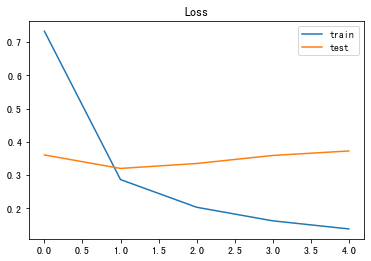

In [22]:
plt.title('Loss')
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show();

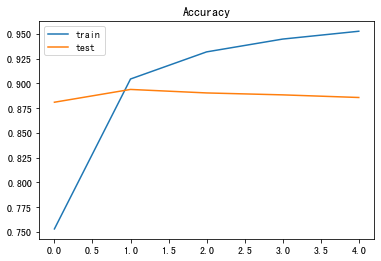

In [26]:
plt.title('Accuracy')
plt.plot(history.history['accuracy'], label='train')
plt.plot(history.history['val_accuracy'], label='test')
plt.legend()
plt.show();

# LSTM模型的评估 

接下来我们通过画混淆矩阵和求F1分数来评估我们模型的表现

In [27]:
y_pred = model.predict(X_test)
y_pred = y_pred.argmax(axis = 1)
Y_test = Y_test.argmax(axis = 1)

Text(0.5, 51.21875, '预测结果')

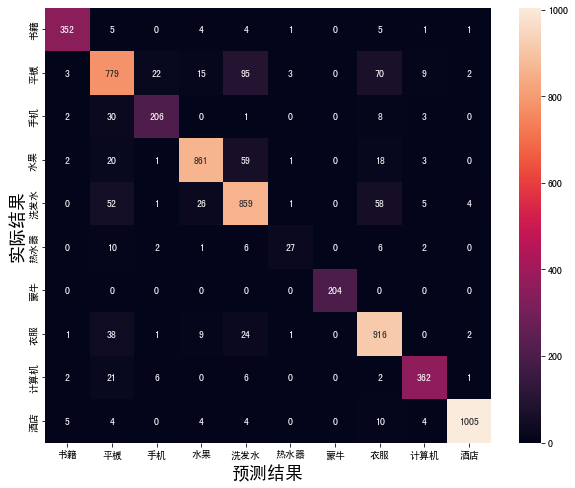

In [29]:
import seaborn as sns
from sklearn.metrics import accuracy_score, confusion_matrix
#生成混淆矩阵
conf_mat = confusion_matrix(Y_test, y_pred)
fig, ax = plt.subplots(figsize=(10,8))
sns.heatmap(conf_mat, annot=True, fmt='d',
            xticklabels=cat_id_df.cat.values, yticklabels=cat_id_df.cat.values)
plt.ylabel('实际结果',fontsize=18)
plt.xlabel('预测结果',fontsize=18)



In [30]:
from  sklearn.metrics import classification_report
 
print('accuracy %s' % accuracy_score(y_pred, Y_test))
print(classification_report(Y_test, y_pred,target_names=cat_id_df['cat'].values))


accuracy 0.8873845173622172
              precision    recall  f1-score   support

          书籍       0.96      0.94      0.95       373
          平板       0.81      0.78      0.80       998
          手机       0.86      0.82      0.84       250
          水果       0.94      0.89      0.91       965
         洗发水       0.81      0.85      0.83      1006
         热水器       0.79      0.50      0.61        54
          蒙牛       1.00      1.00      1.00       204
          衣服       0.84      0.92      0.88       992
         计算机       0.93      0.91      0.92       400
          酒店       0.99      0.97      0.98      1036

    accuracy                           0.89      6278
   macro avg       0.89      0.86      0.87      6278
weighted avg       0.89      0.89      0.89      6278



# 自定义预测

首先我们定义一个预测函数:通过输入一段评语,来预测它的类目

In [31]:
def predict(text):
    txt = remove_punctuation(text)
    txt = [" ".join([w for w in list(jb.cut(txt)) if w not in stopwords])]
    seq = tokenizer.texts_to_sequences(txt)
    padded = pad_sequences(seq, maxlen=MAX_SEQUENCE_LENGTH)
    pred = model.predict(padded)
    cat_id= pred.argmax(axis=1)[0]
    return cat_id_df[cat_id_df.cat_id==cat_id]['cat'].values[0]
      

In [32]:
predict('苹果好吃又不贵，已经买了很多次了')

'水果'

In [33]:
predict('收到产品已经半个多月了，一开始用着不太好用，慢慢的就好使了，可能是习惯问题吧，主要是屏的分辨率真的不错。')

'平板'

In [34]:
predict('可能中外文化理解差异，可能与小孩子太有代沟，不觉得怎么样，还是比较喜欢水墨画一点风格的漫画书，但愿我女儿长大一点能喜欢（22个月中）')

'书籍'

In [35]:
predict('假的，不好用，头皮痒的要命。。。')

'洗发水'

In [36]:
predict('这是第三次点评，纯粹是为了拿积分。没什么可以多说了，服务不错。')

'酒店'

In [37]:
#自定义review
predict('房间挺大，就是价格贵了点')

'酒店'

In [38]:
#自定义review
predict('酸的要死，下次不买了')

'水果'

In [39]:
#自定义review
predict('酸的要死，下次不买了')

'水果'

In [40]:
#自定义review
predict('用了几天就好卡，上当了，退款')

'衣服'

In [41]:
#自定义review
predict('用了几次发现头好痒，感觉过敏了')

'洗发水'

In [42]:
predict('手写识别还可以')

'手机'

In [43]:
predict('T恤很好看，就是短了点')

'衣服'